In [19]:
import os
import shutil
import numpy as np
from numpy import save
import cv2
from matplotlib import pyplot as plt
import random

# 1 ) Data Pre-Processing Overview
* ## The Ottawa Road segmentation data is available at : https://github.com/yhlleo/RoadNet
* ## Put the Ottawa-Dataset folder in the same direcotry as this notebook to follow along
* ## This notebook is used to pre-process only the imagery and segmentation masks (ignoring the center lines and edge annotations)
* ## The imagery are 3 channel RGB
* ## The masks are 3 channel RGB
* ## Data pre-processing will
> ## 1) chip the imagery & masks into smaller 512x512 images
> ## 2) convert the mask imagery to 3 channel Black & White images, where the roads are white [255,255,255] and the background is black [0,0,0].
> ## 3) Split the imagery into training and validation folders
* ## Later, training input (see Unet-Training notebook) image values will be normalized to 0,1 and the masks will be converted to single channel grayscale images and normalized to 0,1. 

# Pre-processing preview: Convert 3-channel color mask to 3-channel B&W mask

In [34]:
dir = 'Ottawa-Dataset/'
imagefile = dir+'20/Ottawa-20.tif'
maskfile = dir+'20/segmentation.png'

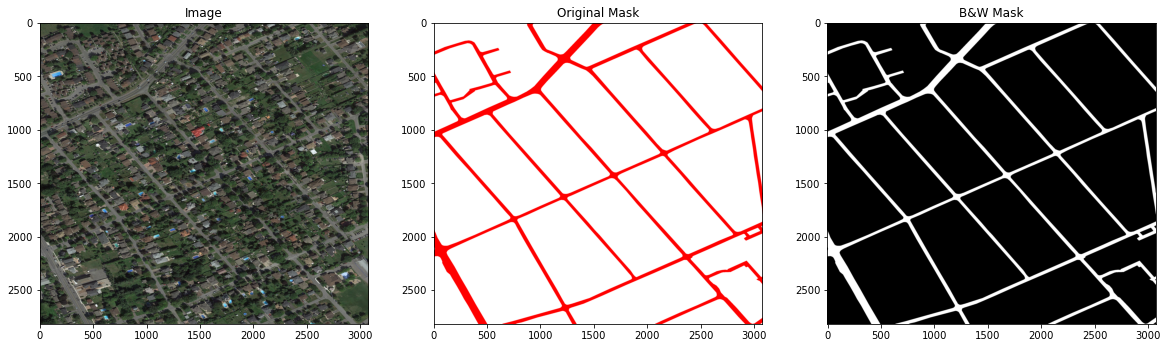

In [16]:
image20 = cv2.imread(imagefile)[...,::-1] # flip the cv2 channels (very important!)
mask20 = cv2.imread(maskfile)[...,::-1] # flip the cv2 channels (very important!)
fig, ax = plt.subplots(1,3,figsize = (20,10))
# B&W mask conversion
mask = np.sum(mask20,axis=2)
mask = np.array(mask != 255.0*3.0,dtype=float) * 255.0
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
# end B&W mask conversion
ax[0].imshow(image20)
ax[1].imshow(mask20)
ax[2].imshow(mask/255.0)
ax[0].set_title('Image');
ax[1].set_title('Original Mask');
ax[2].set_title('B&W Mask');

# Create a list of randomly shuffled training and validation folders from the Ottawa-Dataset

In [47]:
flist = os.listdir(dir)
random.shuffle(flist)
valfolders = flist[-int(len(flist)*0.2):]
trainfolders = flist[:-int(len(flist)*0.2)]
print('shuffled data folder list: ', flist)
print('validation folders: ', valfolders)
print('training folders: ', trainfolders)

shuffled data folder list:  ['11', '20', '17', '1', '13', '9', '15', '7', '3', '5', '6', '4', '16', '10', '12', '18', '14', '2', '8', '19']
validation folders:  ['14', '2', '8', '19']
training folders:  ['11', '20', '17', '1', '13', '9', '15', '7', '3', '5', '6', '4', '16', '10', '12', '18']


# Loop over the images, pre-process them, and add them to either the training or validation folder

In [62]:
### Cut the images into smaller (512x512) chips, 
## convert masks to B&W, write to training 
## and validation folders.

shape = 512 # will be square images

# these folders will get made with os.makedirs
training_folder = 'data/training/'
validation_folder = 'data/validation/'

#make the training data directories
os.makedirs(training_folder+'images/images') # extra folder required for keras image data generator
os.makedirs(training_folder+'masks/images') # extra folder required for keras image data generator

#make the validation data directories
os.makedirs(validation_folder+'images/images')
os.makedirs(validation_folder+'masks/images')

#num = 0
for folder in flist:
    if folder in trainfolders:
        write_to = training_folder
    elif folder in valfolders:
        write_to = validation_folder
    else:
        print('problem with folder', folder)
        
    img = os.path.join(dir,folder, 'Ottawa-'+folder+'.tif')
    seg = os.path.join(dir,folder, 'segmentation.png')
    img = cv2.imread(img) # no need to flip channels since we are just writing back to disk
    seg = cv2.imread(seg)

    # convert the 3 channels rbg masks to 3 channel B&W masks
    seg = np.sum(seg,axis=2)
    seg = np.array(seg != 255.0*3.0, dtype=float) * 255.0
    seg = np.repeat(seg[:, :, np.newaxis], 3, axis=2)

    for row in range(0,img.shape[0],shape):
          for col in range(0,img.shape[1],shape):
            img_crop = np.zeros((shape,shape,3))
            mask_crop = np.zeros((shape,shape,3))

            if row+shape > img.shape[0]:
                rowend = img.shape[0]
            else:
                rowend = row+shape

            if col+shape > img.shape[1]:
                colend = img.shape[1]
            else:
                colend = col+shape

            numrows = img[row:rowend,col:colend].shape[0]
            numcols = img[row:rowend,col:colend].shape[1]
            img_crop[0:numrows,0:numcols] = img[row:rowend,col:colend]
            mask_crop[0:numrows,0:numcols] = seg[row:rowend,col:colend]

            cv2.imwrite(write_to+'/images/images/'+folder+'_'+str(row)+'_'+str(col)+'.png', img_crop)
            cv2.imwrite(write_to+'/masks/images/'+folder+'_'+str(row)+'_'+str(col)+'.png', mask_crop)

# Check the processed training imagery

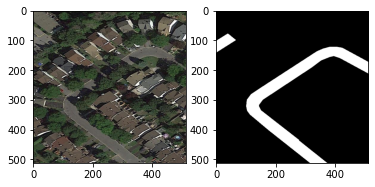

In [63]:
img = cv2.imread('data/training/images/images/13_0_2048.png')[...,::-1]
mask = cv2.imread('data/training/masks/images/13_0_2048.png')
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(mask)

# Check the processed validation imagery

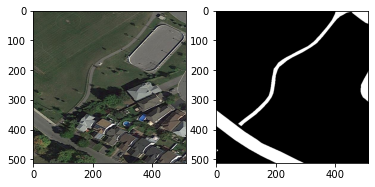

In [65]:
img = cv2.imread('data/validation/images/images/14_1024_512.png')[...,::-1]
mask = cv2.imread('data/validation/masks/images/14_1024_512.png')
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(mask)

In [66]:
print('Number of training chips is', len(os.listdir('data/training/images/images/')))
print('Number of validation chips is', len(os.listdir('data/validation/images/images/')))

Number of training chips is 579
Number of validation chips is 245


# Pre-processing is complete, move on to the Unet-Training notebook